In [1]:
#Libaries and Settings
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
from statsmodels import regression
from pandas import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
%matplotlib inline

import statsmodels.formula.api as sm # module for stats models
from statsmodels.iolib.summary2 import summary_col # module for presenting stats models outputs nicely

In [ ]:
#Premiums
#1. Factors
#2. Single-period diversification premium
#3. Multi-period rebalancing premium

In [2]:
#Fundamental, economic factors
#Natural force risk

#Growth, inflation, volatility, productivity, demographic risk

#Tradeable investment styles
#Static (long) factors: Market portfolio
#Dynamic factors: value-growth, momentum
FF_factor_return = pd.read_csv('Factors_Fama_French_Return_Daily_USD.csv', index_col = 0)
FF_factor_return.head()

#Mkt-Rf = Market-Capitalised Return on all NYSE, AMEX, NASDAQ (from CRSP) i.e. US stocks 
# - 1M Treasury Bill Rate (from Ibbotson Associates)

#SMB = Avg. of Small Value, Small Neutral, Small Growth Portfolios
# - Avg. of Big Value, Big Neutral, Big Growth Portfolios

#HML = Avg. of Small Value, Big Value - Avg. of Small Growth + Big Growth

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
2/01/1970,0.0118,0.0132,0.0097,0.00029,-0.0341
5/01/1970,0.0059,0.0067,0.0076,0.00029,-0.0152
6/01/1970,-0.0074,0.0010,0.0028,0.00029,0.0040
7/01/1970,-0.0015,0.0038,-0.0035,0.00029,0.0011
8/01/1970,0.0004,0.0017,-0.0018,0.00029,0.0033


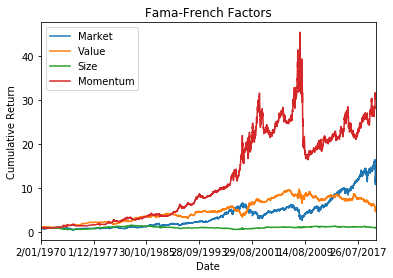

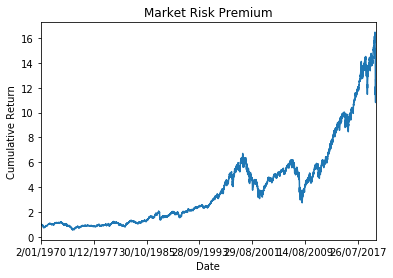

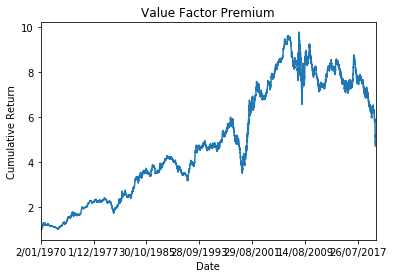

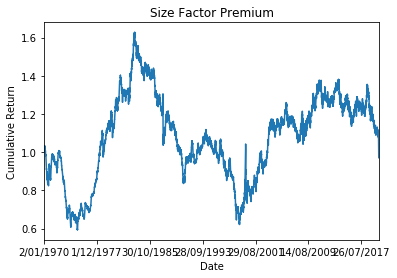

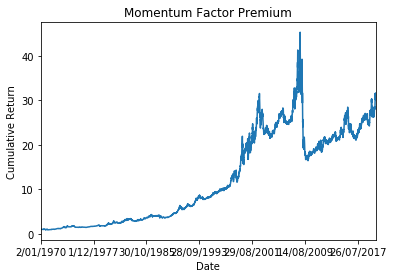

In [3]:
np.cumprod(FF_factor_return['Mkt-RF'] + 1).plot()
np.cumprod(FF_factor_return['HML'] + 1).plot()
np.cumprod(FF_factor_return['SMB'] + 1).plot()
np.cumprod(FF_factor_return['Mom'] + 1).plot()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Fama-French Factors')
plt.legend(['Market', 'Value', 'Size', 'Momentum'])
plt.show()
np.cumprod(FF_factor_return['Mkt-RF'] + 1).plot()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Market Risk Premium')
plt.show()
np.cumprod(FF_factor_return['HML'] + 1).plot()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Value Factor Premium')
plt.show()
#Value stocks move together with other stocks
#Try find other value metrics and see if this is the case / average them
#Much of the value risk is non-diversifiable and must be priced in equilibrium, leading to value premium
#Premium depends on pricing kernel which depends on value losses
#Explained by investment growth, labour income, luxury consumption, housing risk, long-run consumption risk

np.cumprod(FF_factor_return['SMB'] + 1).plot()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Size Factor Premium')
plt.show()
#Size premium disappeared after Banz and Reinganum (1980) studies published
#Thus, higher returns attributed to higher market betas
#Decent if you cannot short or lever
np.cumprod(FF_factor_return['Mom'] + 1).plot()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Momentum Factor Premium')
plt.show()

In [18]:
#Breaking Down Commodity Returns by FF Factors
GSCI = pd.read_csv('Commodities_GSCI_Daily_USD.csv', index_col = 0)
GSCI.index = pd.to_datetime(GSCI.index, format = '%d/%m/%Y')
GSCI_returns = GSCI.pct_change()[1:]

test = FF_factor_return.merge(GSCI_returns['GSCI'], left_index = True, right_index = True)
test['const'] = 1
CAPM = sm.OLS(endog = test['GSCI'] - test['RF'], 
              exog = test[['const', 'Mkt-RF']], missing = 'drop').fit(cov_type = 'HAC', cov_kwds={'maxlags':1})

FF3 = sm.OLS(endog = test['GSCI'] - test['RF'], 
              exog = test[['const', 'Mkt-RF', 'HML', 'SMB']], missing = 'drop').fit(cov_type = 'HAC', cov_kwds={'maxlags':1})

CH4 = sm.OLS(endog = test['GSCI'] - test['RF'], 
              exog = test[['const', 'Mkt-RF', 'HML', 'SMB', 'Mom']], missing = 'drop').fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})


results_table = summary_col(results = [CAPM, FF3, CH4],
                            stars=True,
                            float_format = '%0.4f',
                            model_names = ['CAPM', 'FF 3 Factor', 'Carhart 4 Factor'],
                            info_dict = {'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'Adj R2':lambda x: "{:.4f}".format(x.rsquared_adj), 
                                         'AIC': lambda x: "{:.4f}".format(x.aic), 
                                         'BIC': lambda x: "{:.4f}".format(x.bic)}, 
                             regressor_order = ['Intercept', 'Mkt-RF', 'HML', 'SMB', 'MoM'])
results_table.add_title('Asset Pricing OLS Regressions')
print(results_table)

#CAPM.params
#CAPM.pvalues
#CAPM.rsquared

        Asset Pricing OLS Regressions
          CAPM    FF 3 Factor Carhart 4 Factor
----------------------------------------------
Mkt-RF -0.0153    0.1221      0.0167          
       (0.3186)   (0.3674)    (0.3167)        
HML               1.5942      1.2269          
                  (1.2990)    (0.9841)        
SMB               0.2396      0.2457          
                  (0.2015)    (0.2066)        
Mom                           -0.8020         
                              (0.7040)        
const  0.0027     0.0025      0.0028          
       (0.0017)   (0.0016)    (0.0017)        
N      8888       8888        8888            
Adj R2 -0.0001    0.0026      0.0038          
AIC    -7013.9300 -7036.4615  -7045.7635      
BIC    -6999.7451 -7008.0917  -7010.3013      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [8]:
equities_country_ETF = pd.read_csv('Equities_iShares_Country_ETF_Daily_USD.csv', index_col = 0)
equities_country_ETF.index = pd.to_datetime(equities_country_ETF.index, format = '%d/%m/%Y')
equities_country_ETF_returns = equities_country_ETF.pct_change()[1:]
equities_country_ETF_returns.head()

,ARGT,ECH,EDEN,EFNL,EGPT,EIDO,EIRL,EIS,ENOR,ENZL,...,ICOL,KSA,NGE,PGAL,PIN,QAT,SPY,TUR,UAE,VNM
Date,,,,,,,,,,,,,,,,,,,,,
1993-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.007112,NaN,NaN,NaN
1993-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002119,NaN,NaN,NaN
1993-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.010570,NaN,NaN,NaN
1993-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004185,NaN,NaN,NaN
1993-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000694,NaN,NaN,NaN


In [19]:
test = FF_factor_return.merge(equities_country_ETF_returns['SPY'], left_index = True, right_index = True)
test['const'] = 1

CAPM = sm.OLS(endog = test['SPY'] - test['RF'], 
              exog = test[['const', 'Mkt-RF']], missing = 'drop').fit(cov_type = 'HAC', cov_kwds={'maxlags':1})

FF3 = sm.OLS(endog = test['SPY'] - test['RF'], 
              exog = test[['const', 'Mkt-RF', 'HML', 'SMB']], missing = 'drop').fit(cov_type = 'HAC', cov_kwds={'maxlags':1})

CH4 = sm.OLS(endog = test['SPY'] - test['RF'], 
              exog = test[['const', 'Mkt-RF', 'HML', 'SMB', 'Mom']], missing = 'drop').fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})



results_table = summary_col(results = [CAPM, FF3, CH4],
                            stars=True,
                            float_format = '%0.4f',
                            model_names = ['CAPM', 'FF 3 Factor', 'Carhart 4 Factor'],
                            info_dict = {'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'Adj R2':lambda x: "{:.4f}".format(x.rsquared_adj), 
                                         'AIC': lambda x: "{:.4f}".format(x.aic), 
                                         'BIC': lambda x: "{:.4f}".format(x.bic)}, 
                             regressor_order = ['Intercept', 'Mkt-RF', 'HML', 'SMB', 'MoM'])
results_table.add_title('Asset Pricing OLS Regressions')

print(results_table)

         Asset Pricing OLS Regressions
           CAPM    FF 3 Factor Carhart 4 Factor
-----------------------------------------------
Mkt-RF 0.7151***   0.7164***   0.7192***       
       (0.0226)    (0.0221)    (0.0219)        
HML                0.0324      0.0403          
                   (0.0298)    (0.0323)        
SMB                -0.1438***  -0.1445***      
                   (0.0259)    (0.0258)        
Mom                            0.0165          
                               (0.0233)        
const  0.0001      0.0001      0.0001          
       (0.0001)    (0.0001)    (0.0001)        
N      6030        6030        6030            
Adj R2 0.4994      0.5052      0.5053          
AIC    -40656.9423 -40725.4331 -40724.9907     
BIC    -40643.5333 -40698.6151 -40691.4682     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
#Generate regressions for all assets